# PUB

In [13]:
from pathlib import Path
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import pandas as pd

import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from scripts.read_nh_results import (read_multi_experiment_results, calculate_member_errors)
from neuralhydrology.utils.config import Config

%load_ext autoreload
%autoreload 2

# Load the data

In [3]:
# run_dir = Path("/datadrive/data/runs/azure_nh_runoff_30EPOCH_0306_173310")
# run_dir = Path("/datadrive/data/runs/azure_nh_runoff_30EPOCH_0306_200242")
run_dir = Path("/home/tommy/neuralhydrology/runs/lstm_PUB_azure_3006_101251")

# load config
cfg = Config(run_dir / "config.yml")
cfg.run_dir = run_dir

In [6]:
res_fp = get_test_filepath(run_dir, epoch=30)
preds = get_all_station_ds(res_fp)

100%|██████████| 134/134 [00:00<00:00, 1992.65it/s]


# Load model

In [7]:
# load trained model
model = get_model(cfg).to(cfg.device)
_load_weights(model, cfg)
model

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


Using the model weights from /home/tommy/neuralhydrology/runs/lstm_PUB_azure_3006_101251/model_epoch030.pt


CudaLSTM(
  (embedding_net): InputLayer(
    (statics_embedding): Identity()
    (dynamics_embedding): Identity()
  )
  (lstm): LSTM(25, 64)
  (dropout): Dropout(p=0.4, inplace=False)
  (head): Regression(
    (net): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

# Get training/test dataset

In [44]:
ds = xr.open_dataset("/home/tommy/spatio_temporal/data/ALL_dynamic_ds.nc")

def read_basin_list(txt_path: Path) -> pd.DataFrame:
    return pd.read_csv(txt_path, header=None).rename({0: "station_id"}, axis=1)


train_sids = read_basin_list(cfg.train_basin_file)
test_sids = read_basin_list(cfg.test_basin_file)
train_ds = ds.sel(time=slice(cfg.train_start_date, cfg.train_end_date), station_id=np.isin(ds.station_id, train_sids.station_id))
test_ds = ds.sel(time=slice(cfg.test_start_date, cfg.test_end_date), station_id=np.isin(ds.station_id, test_sids.station_id))

# Check the Performance of model

In [48]:
if "errors" not in globals():
    errors = calculate_all_error_metrics(preds, basin_coord="station_id")
else:
    print("Already run errors!")

Calculating Errors:  27%|██▋       | 36/134 [00:06<00:16,  5.87it/s, 30012]/home/tommy/neuralhydrology/neuralhydrology/evaluation/metrics.py:523: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs)
Calculating Errors:  28%|██▊       | 37/134 [00:06<00:18,  5.23it/s, 30014]/home/tommy/neuralhydrology/neuralhydrology/evaluation/metrics.py:523: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs)
Calculating Errors:  41%|████      | 55/134 [00:09<00:14,  5.39it/s, 38017]/home/tommy/neuralhydrology/neuralhydrology/evaluation/metrics.py:523: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs)
Calculating Errors:  47%|████▋     | 63/134 [00:10<00:10,  6.85it/s, 39114]/home/tommy/neuralhydrology/neuralhydrology/evaluation/metrics.py:523: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs)
Calculating Errors: 100%|██████████| 134/134 [00:22<00:00,  5.94it/s, 96001]


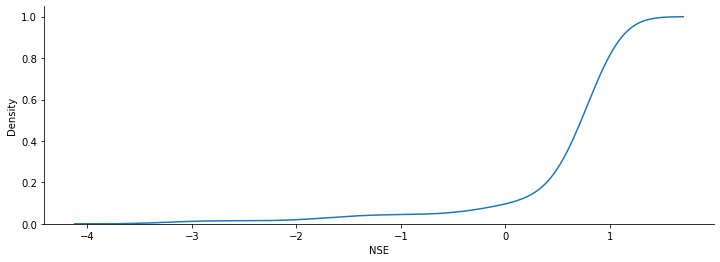

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# da = errors["NSE"].where(errors["NSE"] > 0)
# f, ax = plt.subplots(figsize=(12, 4))
# sns.kdeplot(da.values[np.isfinite(da)], cumulative=True, clip=(0, 1))
# sns.despine()

f, ax = plt.subplots(figsize=(12, 4))
sns.kdeplot(errors["NSE"].values[np.isfinite(errors["NSE"])], cumulative=True)
ax.set_xlabel("NSE")
sns.despine()

In [54]:
def print_summaries(errors: xr.Dataset):
    print(f"Median NSE: \t{float((errors['NSE']).median().values):.2f}")
    print(f"Mean NSE: \t{float((errors['NSE']).mean().values):.2f}")
    print(f"Min NSE: \t{float((errors['NSE']).min().values):.2f}")
    print(f"Max NSE: \t{float((errors['NSE']).max().values):.2f}")
    print(f"P(Errors < 0): \t{(errors['NSE'] < 0).mean().values:.2f}")
    print("\n")

print_summaries(errors)
print_summaries(errors.where(errors["NSE"] > 0))

Median NSE: 	0.78
Mean NSE: 	0.57
Min NSE: 	-3.36
Max NSE: 	0.94
P(Errors < 0): 	0.10


Median NSE: 	0.80
Mean NSE: 	0.75
Min NSE: 	0.10
Max NSE: 	0.94
P(Errors < 0): 	0.00




# Visualise Hydrographs

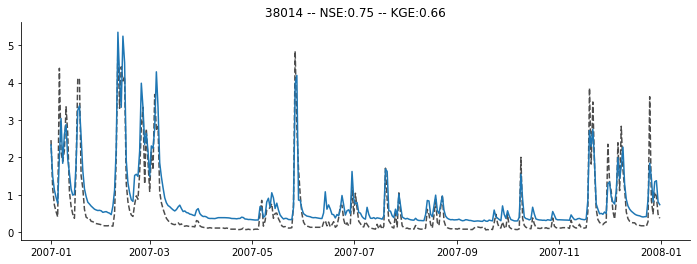

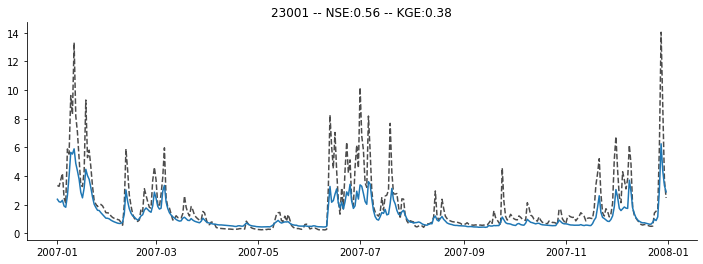

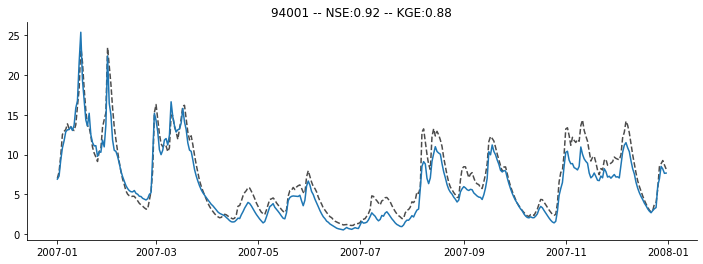

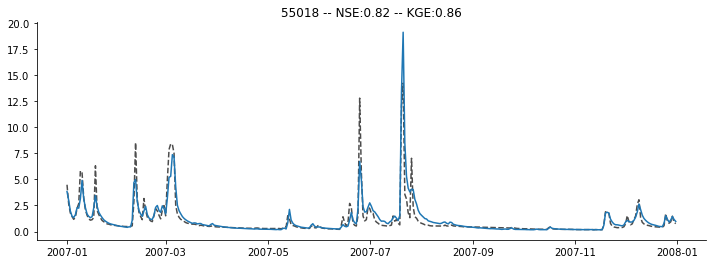

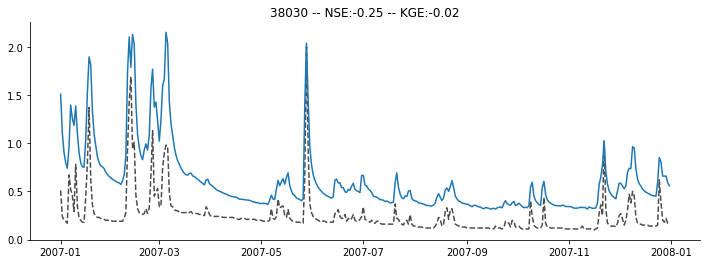

In [55]:
for i in range(5):
    f, ax = plt.subplots(figsize=(12, 4))
    pixel = np.random.choice(preds.station_id.values)
    p = preds.sel(date="2007", station_id=pixel)
    ax.plot(p.date, p["discharge_spec_obs"], label="obs", color="k", ls="--", alpha=0.7)
    ax.plot(p.date, p["discharge_spec_sim"], label="sim")
    
    ax.set_title(f"{pixel} -- NSE:{errors.sel(station_id=pixel).NSE.values:.2f} -- KGE:{errors.sel(station_id=pixel).KGE.values:.2f}")
    sns.despine()

# Visualise Spatially

In [136]:
# comparison
orig_run_dir = Path("/datadrive/data/runs/azure_nh_runoff_30EPOCH_PIXEL_ALL_STATIC_0406_093025")
orig_res_fp = get_test_filepath(orig_run_dir, epoch=30)
orig_preds = get_all_station_ds(orig_res_fp)

if "orig_errors" not in globals():
    orig_errors = calculate_all_error_metrics(orig_preds, basin_coord="station_id")
else:
    print("Already run errors!")

Calculating Errors: 100%|██████████| 669/669 [01:54<00:00,  5.85it/s, 97002]


In [125]:
import geopandas as gpd
from scripts.geospatial import initialise_gb_spatial_plot, load_latlon_points
from mpl_toolkits.axes_grid1 import make_axes_locatable

st_data_dir = Path("/home/tommy/spatio_temporal/data")
points = load_latlon_points(st_data_dir)
errors["station_id"] = errors["station_id"].astype(int)
static = xr.open_dataset(st_data_dir / "camels_static.nc")

In [132]:
np.isin(errors["NSE"].to_dataframe().index, points.index)
gdf = gpd.GeoDataFrame(errors.to_dataframe().join(points))
gdf.head()

,Alpha-NSE,Beta-NSE,FHV,FLV,FMS,KGE,MSE,NSE,Peak-Timing,Pearson-r,RMSE,geometry
station_id,,,,,,,,,,,,
102001,0.776489,0.029981,-27.956629,-781.520613,-17.270340,0.717327,2.962270,0.691630,0.333333,0.834180,1.721125,POINT (-4.36000 53.27000)
107001,0.796392,-0.112059,-16.270611,-81.252962,-15.473061,0.734177,1.415504,0.762444,0.458333,0.884766,1.189750,POINT (-3.23000 59.11000)
12001,0.863555,-0.071826,-12.916905,15.635491,-5.583116,0.831291,0.814746,0.849453,0.391304,0.926600,0.902633,POINT (-2.60000 57.05000)
13005,0.681094,-0.084468,-29.897403,61.376824,-25.897196,0.658191,0.424975,0.831783,0.285714,0.956408,0.651901,POINT (-2.56000 56.64000)
15006,0.966066,0.544577,12.696132,-104.645733,-47.560655,0.558184,3.422372,0.574214,0.440000,0.933715,1.849965,POINT (-3.39000 56.51000)


In [137]:
orig_gdf = gpd.GeoDataFrame(orig_errors.sel(station_id=gdf.index.astype("str")).join(points))

AttributeError: 'Dataset' object has no attribute 'join'

<AxesSubplot:>

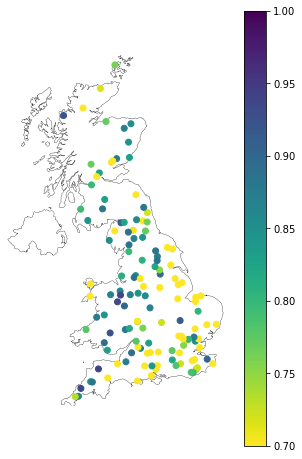

In [130]:
ax = initialise_gb_spatial_plot()
gdf.plot("NSE", ax=ax, vmin=0.7, vmax=1, cmap="viridis_r", legend=True)

ax = initialise_gb_spatial_plot()
orig_gdf.plot("NSE", ax=ax, vmin=0.7, vmax=1, cmap="viridis_r", legend=True)

100%|██████████| 669/669 [00:00<00:00, 2131.28it/s]
